# 005.0 - Basic Prediction Models - TODO

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('..')
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.utils import get_clean_season, make_interim_data, get_interim_data_fps
from src.model_selection.resampling import league_split, historical_season_split
from src.data.historical_records import form_historical_records
from src.features.custom_transformers import LastNGames, DropNthColumn, ImputeRows, IdentityTransformer, \
                                            OrderedSet, DropHistoriesAnyNaNFeatures
from src.metrics.rps_metrics import rps_mean
from src.model_selection.test_harness import simulate_season

In [2]:
def run_pipeline(test_season, X, y, pipeline, split_method):

    for train_ind, val_ind in split_method(test_season, pred_set_start=3):
        # Set up using the prediction set indices
        X_train, y_train, X_val, y_val = X.iloc[train_ind], y.iloc[train_ind], X.iloc[val_ind], y.iloc[val_ind]
        # Pipeline Process
#         print(pipeline)
#         print(pipeline.steps[0])
        for preprocess in pipeline.steps[:-1]:
            #print(X_train)
            #print('preprocess', preprocess)
            preprocess[1].fit(X_train)
            X_train = preprocess[1].transform(X_train)
            #X_train_preprocd = preprocess[1].fit_transform(X_train)
            #print(X_train)
        fitted_model = pipeline.steps[-1][1].fit(X_train, y_train)
        # validation
        for preprocess in pipeline.steps[:-1]:
            preprocess[1].fit(X_val)
            X_val = preprocess[1].transform(X_val)
            #X_val_preprocd = preprocess[1].fit_transform(X_val)
        val_result = fitted_model.predict_proba(X_val)
        #print(val_result)
        # Put the predicted probabilities into the dataFrame
#         print('in pipeline')
#         print(fitted_model.classes_)
        prob_col_names = ['p_' + class_ +'_model' for class_ in fitted_model.classes_] 
        # Create columns so can be inserted into later 
        test_season = pd.concat([test_season, pd.DataFrame(columns = prob_col_names)], sort=False)
        test_season.loc[val_ind, prob_col_names] = val_result
    return test_season


def get_EVs(test_season, stake):
    for bet in ['hwin', 'draw', 'awin']:
        p_win = test_season['p_'+ bet +'_model']
        p_lose = 1 - p_win
        test_season['EV_' + bet] = ((test_season[bet + '_odds']-1)*p_win*stake) - (p_lose*stake)
    return test_season


def get_max_game_EVs(test_season):
    test_season['EV_max_per_game'] = test_season[['EV_hwin', 'EV_draw', 'EV_awin']].max(axis=1)

def get_best_bet_game(test_season):
    pass
    # test_season['highest_EV_bet_game'] = test_season[['EV_hwin', 'EV_draw', 'EV_awin']].idxmax(axis=1).as_str.apply(lambda x: x = x.split('_')[1])


def setup_encoded_bet_results(test_season):
    test_season['result_hwin'] = test_season['result'] == 'hwin'
    test_season['result_draw'] = test_season['result'] == 'draw'
    test_season['result_awin'] = test_season['result'] == 'awin'

    return test_season

def simulate_bets(test_season, ev_threshold, stake, ev_best_per_game=True):
    # Set up a return of 0 for each event
    # We may make multiple bets on the same event if we get 2 positive EVs
    # So need to add a positive or negative value to this initial zero setting
    test_season['return'] = 0
    for bet in ['hwin', 'draw', 'awin']:
        make_bet = test_season['EV_' + bet] > ev_threshold
        win = test_season['result'] == bet
        lose = test_season['result'] != bet
        
        make_bet_and_win = make_bet & win
        make_bet_and_lose = make_bet & lose
        test_season.loc[make_bet_and_win, 'return'] += \
                    test_season['return'] + ((test_season[bet + '_odds'] - 1.0) * stake)
            
        test_season.loc[make_bet_and_lose, 'return'] += - stake

    return test_season


def simulate_predictions(test_season, X, y, pipeline, split_method, ev_threshold=0.1, stake=1):
    """
    
    """
#     print('in simulate season')
    test_season = run_pipeline(test_season, X, y, pipeline, split_method)
    test_season = get_EVs(test_season, stake)
    test_season = setup_encoded_bet_results(test_season)
    test_season = simulate_bets(test_season, ev_threshold, stake)
    return test_season

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                            GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC

from src.model_selection.resampling import historical_season_split

fl = get_interim_data_fps()
season = get_clean_season(fl[0], '2014-2015')
season_history = form_historical_records(season)

#feature_cols =  [col for col in season_history.columns if col[-1].isdigit()]
feature_cols =  [col for col in season_history.columns if 'sot' in col]
X = season_history[feature_cols]
y = season['result']



nb_pipeline = Pipeline([('drop0_col', DropNthColumn(nth_col=0)),
                        ('last_n_games', LastNGames(n_games=3)),
                        ('impute_rows', ImputeRows(impute_method='mean')),
                        ('impute_cols', SimpleImputer(missing_values=np.nan, strategy='mean')),
                        ('Scaler', StandardScaler()),
                        ('Linear-Discriminant-Analysis',
                                          LinearDiscriminantAnalysis(solver='lsqr',
                                                                     shrinkage='auto',
                                                                    tol=1.0e-7))])#AdaBoostClassifier(base_estimator=SVC(probability=True),
                                                              #     algorithm='SAMME',
                                                              #     n_estimators=100,
                                                              #     learning_rate=0.1))])

stake = 100
ev_threshold = 1.0 * stake
#ev_threshold = 1.6 * stake

test_season = simulate_predictions(season_history, X, y, nb_pipeline, historical_season_split,
                              ev_threshold=ev_threshold, stake=stake)
test_season.iloc[350:360]

,h,h_h_goals_0,h_h_goals_-1,h_h_goals_-2,h_h_goals_-3,h_h_goals_-4,h_h_goals_-5,h_h_goals_-6,h_h_goals_-7,h_h_goals_-8,...,p_awin_model,p_draw_model,p_hwin_model,EV_hwin,EV_draw,EV_awin,result_hwin,result_draw,result_awin,return
350,Crystal Palace,1.0,0.0,0.0,2.0,3.0,1.0,1.0,0.0,2.0,...,0.369067,0.221399,0.409534,94.5285,-20.739,-30.6154,False,False,True,0.0
351,Hull,0.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0,2.0,...,0.140017,0.397399,0.462584,-12.109,38.6921,-32.9317,False,False,True,0.0
352,Aston Villa,1.0,3.0,3.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.281838,0.358131,0.360031,-34.8344,36.4479,38.1006,True,False,False,0.0
353,Stoke,3.0,1.0,2.0,1.0,2.0,1.0,1.0,3.0,1.0,...,0.227583,0.246889,0.525528,78.6797,-14.8235,-47.8835,True,False,False,0.0
354,Leicester,2.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,...,0.419973,0.375918,0.204109,-44.0742,26.6845,17.1724,True,False,False,0.0
355,Newcastle,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,...,0.428276,0.33034,0.241384,-46.4127,13.637,53.3227,False,True,False,0.0
356,Chelsea,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,0.221367,0.174892,0.603741,31.6154,-39.4872,-18.7583,False,True,False,0.0
357,Man City,6.0,3.0,2.0,3.0,2.0,5.0,1.0,0.0,3.0,...,0.274782,0.15516,0.570058,-31.593,25.0593,327.56,True,False,False,-100.0
358,Arsenal,0.0,0.0,4.0,3.0,2.0,2.0,5.0,3.0,2.0,...,0.364537,0.208733,0.42673,-42.8182,17.3078,268.183,False,False,True,910.0
359,Burnley,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,2.0,...,0.177664,0.443682,0.378654,-3.44335,46.8588,-45.6347,False,True,False,0.0


In [7]:
season_return = test_season['return'].sum()

print(f'stake:\t\t{stake}')
print(f'season return:\t{season_return}')

n_bets = test_season[test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold]
make_bet = test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold
n_bets = make_bet.sum()
tot_bets = n_bets.sum().sum()

print(f'n_bets:\n{n_bets}\n')
print(f'tot_bets:\n{tot_bets}\n')

return_per_bet = round(season_return/tot_bets, 2)
overall_return = round(1 + season_return/(tot_bets * stake),3)
print(f'return_per_bet:\n{return_per_bet}\n')
print(f'overall_return:\n{overall_return}\n')

stake:		100
season return:	969.0
n_bets:
EV_hwin    30
EV_draw    20
EV_awin    62
dtype: int64

tot_bets:
112

return_per_bet:
8.65

overall_return:
1.087



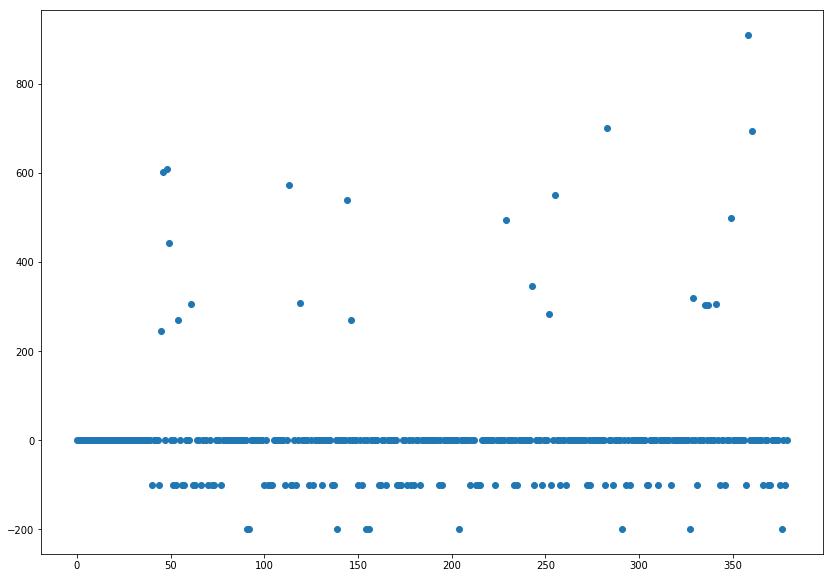

In [8]:
fig, ax = plt.subplots(figsize=(14,10))
plt.plot(test_season.index, test_season['return'], 'o')
plt.show();